In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import sys
sys.path.append('../../')

import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow import gfile
import numpy as np
from tgs import data
import time
from matplotlib import pyplot as plt
from PIL import Image
import os

np.set_printoptions(suppress=True,linewidth=np.nan,threshold=np.nan)

/home/jfaath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
config_dict = {
    'train_file_pattern': '../data/train/tfrecord/tgs*',
    'valid_file_pattern': '../data/valid/tfrecord/tgs*',
    'test_file_pattern': '../data/test/tfrecord/tgs*',
    'shuf_buf': 50000,
    'parallel_calls': 8,
    'ext': {
        'resize_dim': 128,
        'resize_method': 'pad',
        'min_padding': 5
    }
}

batch_size = 20
num_epochs = 1

def run_data(idi, mode=tf.estimator.ModeKeys.TRAIN, iters=None, resize_mth='pad', augment=None, resize=None):
    if iters is None:
        iters = 999999
    
    sess = tf.InteractiveSession()
    d = idi.input_fn(mode, augment, resize)
    cnt = 0
    ids = []
    imgs = []
    masks = []
    resizes = []
    while True:
        try:
            img_dict, mask = sess.run(d)
            ids.extend(img_dict['id'])
            imgs.extend(img_dict['img'])
            masks.extend(mask)
            resizes.extend(img_dict[resize_mth])
            cnt += 1
            if cnt > iters:
                break
        except tf.errors.OutOfRangeError:
            print(f"Epoch finished on iteration {cnt}")
            break

    sess.close()
    tf.reset_default_graph()
    
    return ids, np.asarray(imgs), np.asarray(masks), np.asarray(resizes)


def plot_images_and_masks(ids, imgs, masks, count=4):
    fig, axes = plt.subplots(nrows=count, ncols=2, figsize=(10, 10 * (count // 2)), sharex=True, sharey=True)
    ax = axes.ravel()

    for i in range(count):
        ax[i * 2].imshow(imgs[i], cmap=plt.cm.gray, interpolation='none', aspect='auto')
        if isinstance(ids[i], str):
            img_id = ids[i]
        else:
            img_id = ids[i].decode()
        ax[i * 2].set_title(img_id)
        ax[i * 2 + 1].imshow(masks[i], cmap=plt.cm.gray, interpolation='none', aspect='auto')


In [14]:
%%time
augment = {'crop': 0.25, 'brightness': None}
# augment = None
# resize = [[13, 14], [13, 14], [0,0]]
resize = None
idi = data.ImageDataInput(config_dict,
                          batch_size=batch_size,
                          num_epochs=num_epochs,
                          preprocess=False)
resize_mth = config_dict['ext']['resize_method']
ids, imgs, masks, resizes = run_data(idi, iters=None, 
                                     mode=tf.estimator.ModeKeys.TRAIN, resize_mth=resize_mth, 
                                     augment=augment,
                                     resize=resize)

INFO:tensorflow:File pattern: ../data/train/tfrecord/tgs*
Epoch finished on iteration 170
CPU times: user 11.7 s, sys: 625 ms, total: 12.3 s
Wall time: 1.87 s


In [15]:
np.sum(masks[9]==0) + np.sum(masks[9]==255)

16384

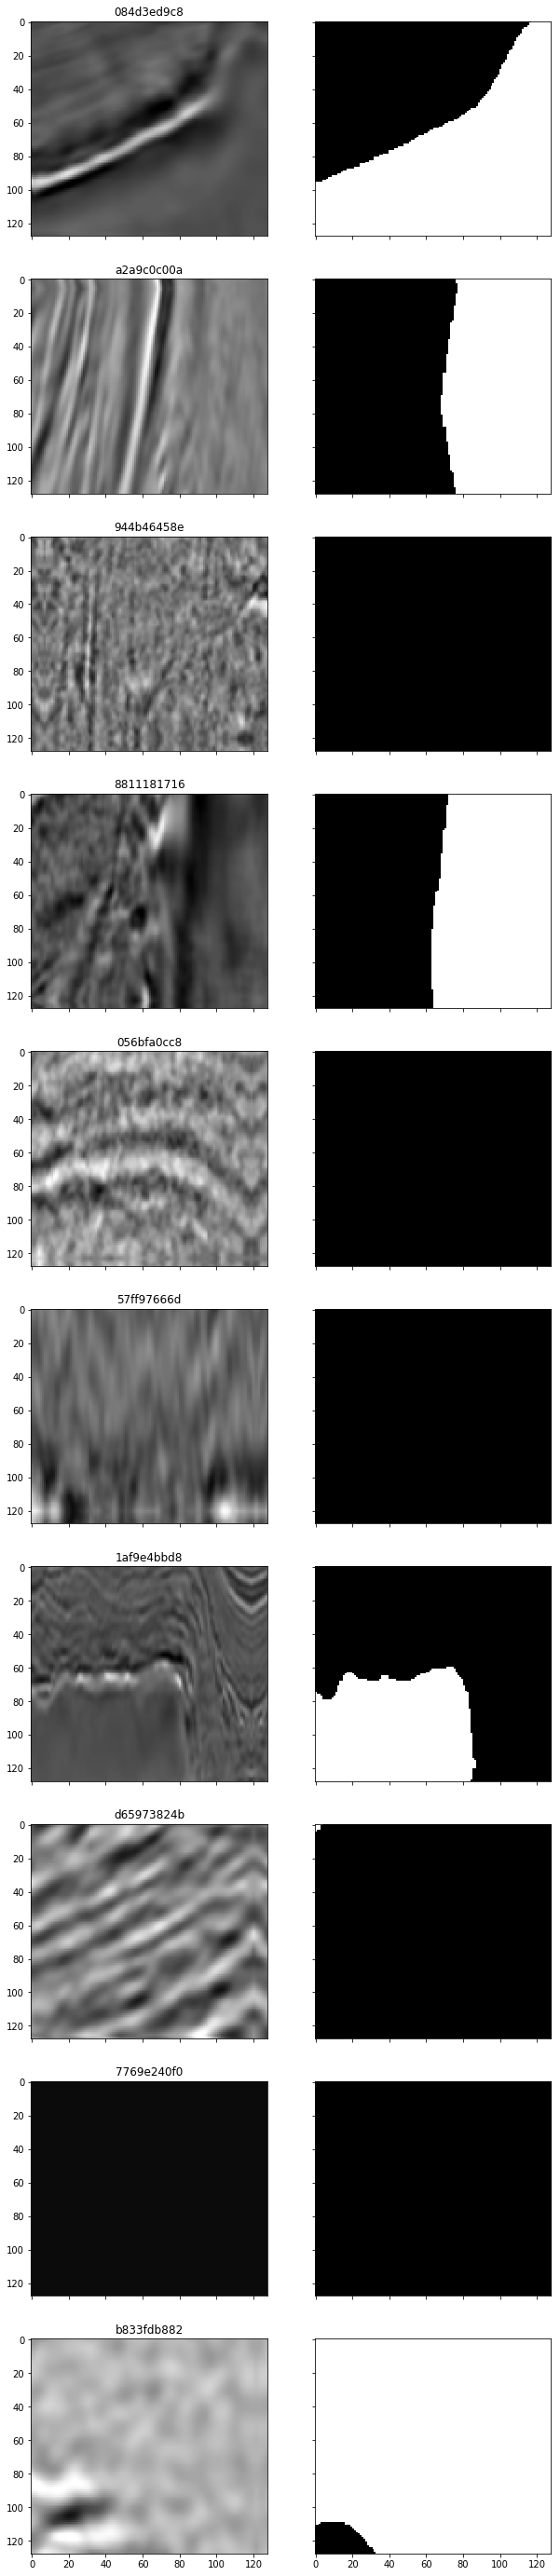

In [16]:
plot_images_and_masks(ids, imgs, masks, count=10)

In [ ]:
idx = 0

print('IMAGES')
print(f'shape: {imgs[idx].shape}, dtype: {imgs[idx].dtype}')
print(f'min: {np.min(imgs[idx])}, max: {np.max(imgs[idx])}')
print('MASKS')
print(f'shape: {masks[idx].shape}, dtype: {masks[idx].dtype}')
print(f'min: {np.min(masks[1])}, max: {np.max(masks[1])}')

In [ ]:
cnt = 2
images_pre = imgs[0:cnt]
masks_pre = masks[0:cnt]

transforms = [[1., 0., 0., 0., 1., 0., 0.001, 0.001]]

imgt = tf.contrib.image.transform(images_pre, transforms, interpolation='NEAREST')
maskt = tf.contrib.image.transform(tf.expand_dims(masks_pre, axis=-1), transforms, interpolation='NEAREST')
maskt = tf.squeeze(maskt, axis=-1)

with tf.Session() as s:
    imgtt, masktt = s.run([imgt, maskt])
    
tf.reset_default_graph()

In [ ]:
plot_images_and_masks(ids, imgtt, masktt, count=cnt)

In [ ]:
%%time
# augment = {'flip': None, 'rotation': 10}
augment = None
idi = data.ImageDataInputBinaryMask(config_dict,
                                    batch_size=batch_size,
                                    num_epochs=num_epochs,
                                    preprocess=False)
resize_mth = config_dict['ext']['resize_method']
ids, imgs, masks, resizes = run_data(idi, iters=None, 
                                     mode=tf.estimator.ModeKeys.EVAL, resize_mth=resize_mth, augment=augment)

In [ ]:
i = 15
print(masks[i])
print(ids[i])

In [ ]:
mask_expr = '../data/raw/masks/*.png'
mask_file = tf.gfile.Glob(mask_expr)

ids = []
imgs = []
masks = []
mask_sums = []
for mf in mask_file:
    img_id = os.path.splitext(os.path.basename(mf))[0]
    ids.append(img_id)
    
    img_file = os.path.join(os.path.dirname(mf), '..', 'images', f'{img_id}.png')
    imga = np.asarray(Image.open(img_file))
    imgs.append(imga)
    
    maska = np.asarray(Image.open(mf))
    masks.append(maska)
    mask_sums.append(np.sum(maska > 0))
    
ids = np.asarray(ids)
imgs = np.asarray(imgs)
masks = np.asarray(masks)
mask_sums = np.asarray(mask_sums)

In [ ]:
small = 350

idx_sm = np.where(np.logical_and(mask_sums >= 250, mask_sums < small))[0]
print(f'small count: {len(idx_sm)}')
ids_sm = ids[idx_sm]
imgs_sm = imgs[idx_sm]
masks_sm = masks[idx_sm]

In [ ]:
plot_images_and_masks(ids_sm, imgs_sm, masks_sm, count=62)

In [ ]:
imgs_vert = []
masks_vert = []

for d in ids_vert:
    img_file = os.path.join('../data/raw/images/' f'{d}.png')
    imga = np.asarray(Image.open(img_file))
    imgs_vert.append(imga)
    
    mask_file = os.path.join('../data/raw/masks/' f'{d}.png')
    maska = np.asarray(Image.open(mask_file))
    masks_vert.append(maska)

imgs_vert = np.asarray(imgs_vert)
masks_vert = np.asarray(masks_vert)
print(len(ids_vert))

In [ ]:
plot_images_and_masks(ids_vert, imgs_vert, masks_vert, count=len(ids_vert))